In [1]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt


from utils.ode import hydrogen_bromine, hydrogen_bromine_init, map_equation, rober, rober_init

from models import WeightedLasso

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from scipy.integrate import solve_ivp


%load_ext autoreload
%autoreload 2

In [27]:
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12


dt = 0.01
x0_train = rober_init
t_train = np.arange(0, 1e2, dt)
t_train_span = (t_train[0], t_train[-1])

data = solve_ivp(
    rober,
    t_train_span,
    x0_train,
    rtol=1e-12,
    atol=1e-12,
    method='LSODA',
    t_eval=t_train,
)

X = data.y.T

print("Generated X shape:", X.shape)
print("t_train shape:", t_train.shape)

library = ps.PolynomialLibrary(degree=3)
library.fit(X)

true_parameters = map_equation(rober, library)

model = ps.SINDy(
    feature_library=library,
    optimizer=WeightedLasso(
        alpha=1e-8, weights=(1 / (np.abs(true_parameters) + 1e-2)).T, max_iter=100_000_000
    ),
    differentiation_method=ps.FiniteDifference(),
)

model.fit(x=X, t=t_train)
model.print()

# param_grid = {
#     "optimizer__alpha": np.logspace(-4, 4, 9),
#     "optimizer__weights": [
#         (1 / (np.abs(true_parameters) + 1e-12)).T,
#         (1 / (np.abs(true_parameters) + 1e-10)).T,
#         (1 / (np.abs(true_parameters) + 1e-8)).T,
#         (1 / (np.abs(true_parameters) + 1e-6)).T,
#         (1 / (np.abs(true_parameters) + 1e-4)).T,
#         (1 / (np.abs(true_parameters) + 1e-2)).T,
#     ],
#     "differentiation_method__order": [1, 2]
# }

# search = GridSearchCV(
#     model,
#     param_grid,
#     cv=TimeSeriesSplit(n_splits=5)
# )


# search.fit(X, t_train)

# print("Best parameters:", search.best_params_)
# search.best_estimator_.print()
# model = search.best_estimator_

Generated X shape: (10000, 3)
t_train shape: (10000,)
(x0)' = -6.642 x1 x2
(x1)' = 40720.406 x1^2 + -6659.228 x1 x2 + -0.001 x1^2 x2
(x2)' = 6818.515 x1^2


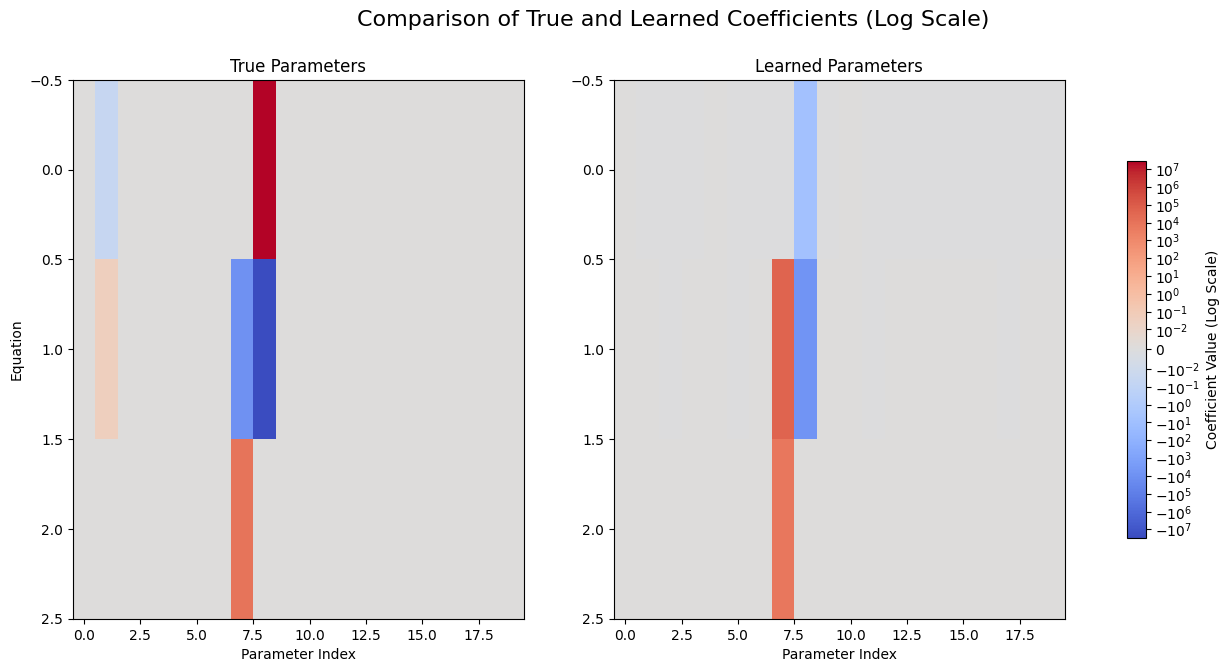

In [28]:
import matplotlib.colors as colors

learned_coefficients = model.coefficients()
# learned_coefficients[np.abs(learned_coefficients) < 1e-4] = 0.0
# true_parameters[np.abs(true_parameters) < 1e-4] = 0.0 # Also clean true params for fairness

# Reshape from 1D vector (100,) to 2D column vector (100, 1) for imshow
# true_params_2d = true_parameters.reshape(-1, 1)
# learned_coeffs_2d = learned_coefficients.reshape(-1, 1)


# --- 3. Set up Shared Color Scale ---
# Find the maximum absolute value across BOTH arrays to center the color map
abs_max = max(np.abs(true_parameters).max(), np.abs(learned_coefficients).max())

# Set vmin and vmax to be symmetric around zero.
vmin = -abs_max
vmax = abs_max

# Create the symmetric log normalizer
# linthresh: The range within which the plot is linear (-linthresh to +linthresh)
# A smaller value makes the log scale apply to smaller numbers.
linthresh = 1e-2
log_norm = colors.SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10)


# --- 4. Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Comparison of True and Learned Coefficients (Log Scale)', fontsize=16)

# Plot True Parameters
im1 = ax[0].imshow(
    true_parameters,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the shared log normalization
)
ax[0].set_title('True Parameters')
ax[0].set_xlabel('Parameter Index')
ax[0].set_ylabel('Equation')
# ax[0].set_xticks([]) # Hide x-axis ticks as they are not meaningful

# Plot Learned Parameters
im2 = ax[1].imshow(
    learned_coefficients,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the SAME shared log normalization
)
ax[1].set_title('Learned Parameters')
ax[1].set_xlabel('Parameter Index')
# ax[1].set_xticks([])
# ax[1].set_yticks([]) # Hide y-axis ticks for the second plot

# Add a single, shared colorbar
fig.colorbar(im2, ax=ax, orientation='vertical', label='Coefficient Value (Log Scale)', shrink=0.7)

# plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

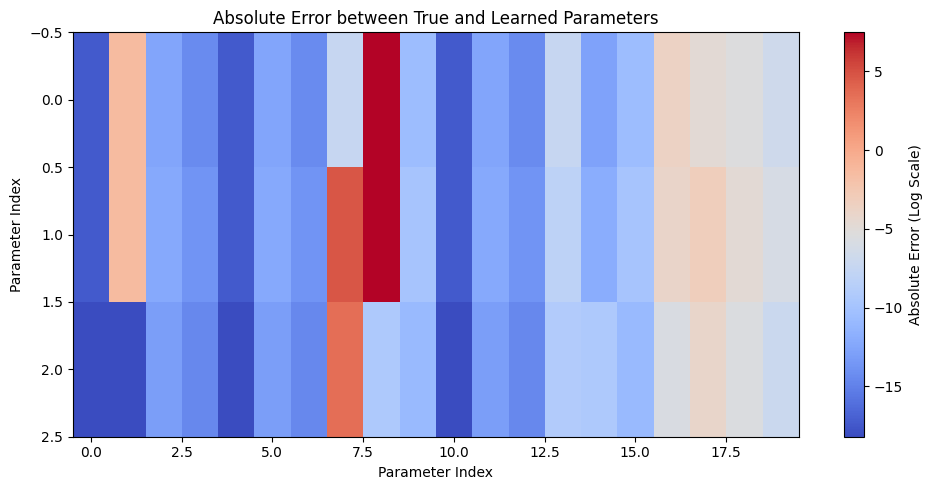

In [29]:
error = np.log10(np.abs(true_parameters - learned_coefficients))


# error = np.where(
#     np.abs(true_parameters) < 1e-4, 0.0, error
# )


plt.figure(figsize=(10, 5))
plt.imshow(
    error,
    aspect='auto',
    cmap='coolwarm',
)
plt.title('Absolute Error between True and Learned Parameters')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Index')
plt.colorbar(label='Absolute Error (Log Scale)')
plt.tight_layout()
plt.show()


In [30]:
true_parameters.shape, learned_coefficients.shape


((3, 20), (3, 20))

In [31]:
# thresholded_coefficients = np.where(
#     np.abs(learned_coefficients) < 1e-4, 0.0, learned_coefficients
# )
# model.coef_ = thresholded_coefficients

x_sim = model.simulate(rober_init, t_train)

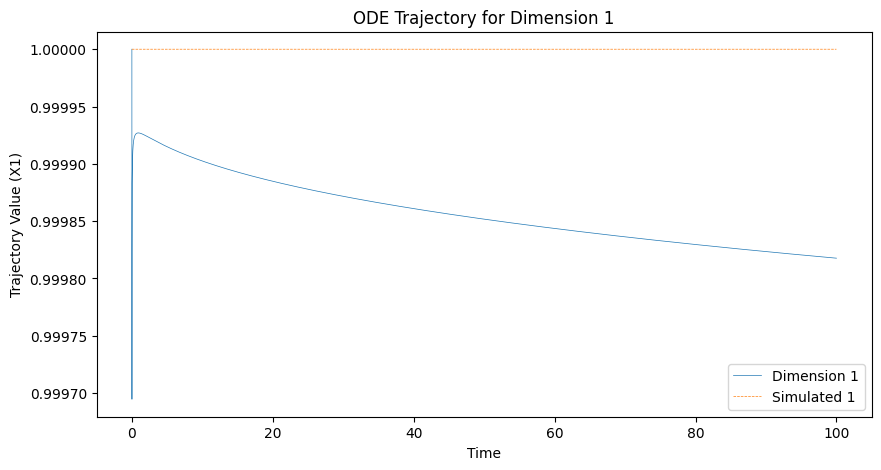

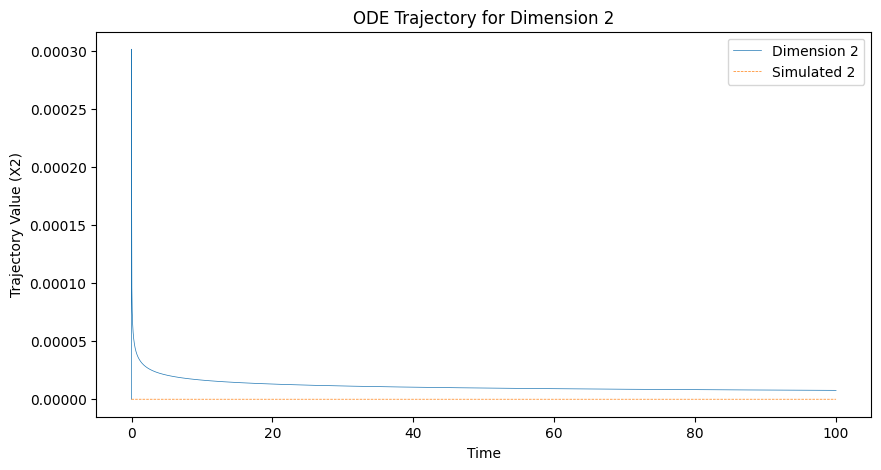

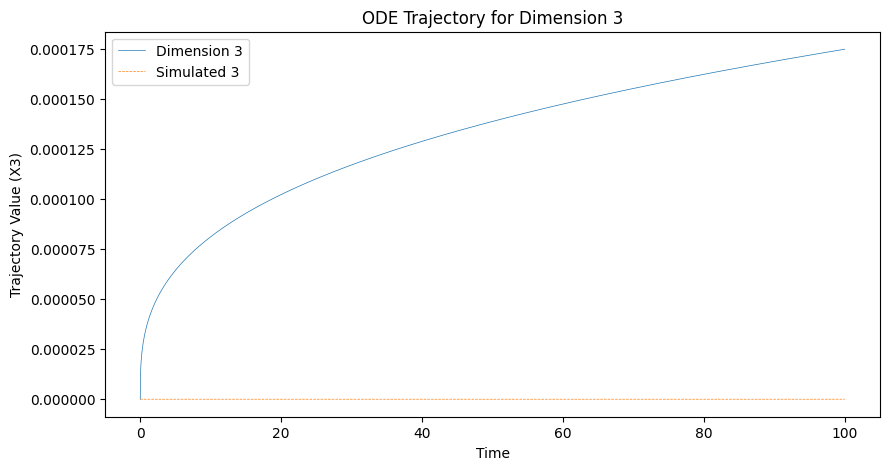

In [32]:
for i in range(X.shape[1]):
    plt.figure(figsize=(10, 5))
    # plt.plot(t_train, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.plot(data.t, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.plot(t_train, x_sim[:, i], label=f"Simulated {i+1}", lw=0.5, linestyle='--')
    plt.xlabel("Time")
    plt.ylabel(f"Trajectory Value (X{i+1})")
    plt.title(f"ODE Trajectory for Dimension {i+1}")
    plt.legend()
    plt.show()